# You need to install:
git clone https://github.com/jpierel14/tweakreg_hack

cd tweakreg_hack

pip install .

### IMPORTANT! This routine does only fix the wcs info in the wcs 'asdf' extension of the fits image. It does NOT update the approximate WCS solution in the fits header (yet, we are working on  it). Here is an example how you can convert from x,y to ra,dec and back using the updated WCS info in the asdf extension:

from jwst import datamodels

image_model = datamodels.ImageModel('jw01018003001_02101_00001_nrca1_tweakregstep.fits')

world_to_detector = image_model.meta.wcs.get_transform('world', 'detector')

x, y = world_to_detector(ra,dec)

detector_to_world = image_model.meta.wcs.get_transform('detector', 'world')

ra, dec = detector_to_world(x,y)


In [1]:
from jwst_wcs_align import jwst_wcs_align,hst_wcs_align
from jwst.datamodels import ImageModel
import re,os
from jwst_wcs_align import initplot, rotate_d_and_find_binmax, sigmacut_d_rot, infoplots
import matplotlib.pyplot as plt

#input_image='/ifs/jwst/wit/nircam/commissioning/01069/obsnum2/jw01069002004_06101_00002_nrcb3_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb3_full_f200w_clear.distcoeff.asdf'
#input_image='/ifs/jwst/wit/nircam/commissioning/01069/obsnum2/jw01069002002_02101_00002_nrca1_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrca1_full_f070w_clear.distcoeff.asdf'
#input_image='/ifs/jwst/wit/nircam/commissioning/01074/obsnum3/jw01074003001_04101_00002_nrcb3_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb3_full_f150w_clear.distcoeff.asdf'
#input_image='/Users/jpierel/Projects/JWST/jwst_distortions_tools/justin/v1/jw01069002002_04101_00001_nrcb4_tweakregstep.fits'
#input_image = '/Users/jpierel/Projects/JWST/jdat_notebooks/notebooks/aperture_photometry/2013ej/jw02107-o040_t018_nircam_clear-f300m_i2d.fits'
input_image = '/Users/jpierel/CodeBase/manuscript_jupyter/sn2013ej/HST/ICW701030/icw701030_drc.fits'
distortion_file = None#'justin/final_CRDS/v1.1/nrcb4_full_f150w_clear.distcoeff.asdf'

### output will be saved in  f'{outrootdir}/{outsubdir}'
### !!!!!! Choose the appropriate outdir!
outrootdir = './test'
outsubdir = 'wcs_align/v1'
wcs_align = hst_wcs_align('HST','F438W',2,3,'IUV2CC_1K1')
from jwst import source_catalog
from jwst import datamodels
import os,subprocess

verbose=2
wcs_align.verbose=verbose
wcs_align.set_outdir(outrootdir, outsubdir)
### get some info about the image
#image_model = ImageModel(input_image)
#wcs_align.phot.load_image(input_image)
#(ra0,dec0,radius_deg)=wcs_align.phot.get_radecinfo_image()
#from simple_jwst_phot_pipe import get_astroquery_cat
#get_astroquery_cat(ra0,dec0,radius_deg,catalog_name='Panstarrs')
#wcs_align.phot.load_refcat('Panstarrs',ra0,dec0,radius_deg,refcat_magcol='gMeanApMag',
#                          refcat_racol='raMean',refcat_deccol='decMean',
#                          refcat_magerrcol='gMeanApMagErr',refcat_color='gMeanApMag_rMeanApMag')
#print(wcs_align.phot.refcat.t)
#sys.exit()
from astropy.io import fits
from astropy import wcs
import jwst
from collections import OrderedDict
#print(wcs.WCS(fits.open(input_image)[5]))
#print(jwst.datamodels.open(input_image).meta.wcs.to_fits_sip(max_pix_error=0.1,
#                                               max_inv_pix_error=0.1,
#                                               degree=2,
#                                               npoints=128).__dict__['_cards'])
#print(f'Info: outdir:{wcs_align.outdir}\n{os.path.basename(input_image)}: {image_model.meta.aperture.name} {image_model.meta.instrument.filter} {image_model.meta.instrument.pupil}')

2022-09-22 16:20:57,761 - stpipe - WARNING - AstropyDeprecationWarning: Module 'tweakwcs.tpwcs' has been deprecated since version 0.8.0. Please use corrector classes from the 'tweakwcs.correctors' module.




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


In [2]:
overwrite = True
skip_applydistortions_if_exists=False
skip_if_exists = False
#refcatname = './LMC_gaia_DR3.nrcposs'
refcatname = 'Panstarrs'
refcat_racol = None # if None, then set automatically
refcat_deccol = None # if None, then set automatically
pmflag = False
pm_median = False
photfilename = 'auto'
load_photcat_if_exists = False
rematch_refcat = True
use_dq=False
DNunits=True
SNR_min = 10
d2d_max = None # maximum distance refcat to source in image
dmag_max = 0.1 # maximum uncertainty of source 
sharpness_lim = (0.4,0.9)
#delta_mag_lim = (-30,-28) # limits on mag-refcat_mainfilter for FGS!
delta_mag_lim = (None,None) #(-26.5,-24.0) # limits on mag-refcat_mainfilter for NRC W filters! 
Nbright4match=1000 # Use only the brightest Nbright4match sources to match to the refcat catalog
Nbright= 1000  # Use only the brightest Nbright sources from image
# showplots=0: no plots
# showplots=1: important plots
# showplots=2: all plots
# showplots=3: debug plots
showplots=2
saveplots=1
savephottable=2


In [3]:
# apply distortion coefficients if wanted.
# the output file with the new distortions has the suffix _assignwcsstep.fits
if distortion_file is not None:
    # apply distortion terms
    (runflag,calimname) = wcs_align.run_applydistortions(input_image,
                                                    distortion_file,
                                                    overwrite = overwrite, 
                                                    skip_if_exists = (skip_applydistortions_if_exists |  skip_if_exists))
else:
    calimname = input_image
    photfilename = re.sub('\.fits$','',os.path.basename(input_image))
    photfilename = f'{wcs_align.outdir}/{photfilename}.phot.txt'
print(f'Done!\nimage: {calimname}\nphotometry file: {photfilename}')


Done!
image: /Users/jpierel/CodeBase/manuscript_jupyter/sn2013ej/HST/ICW701030/icw701030_drc.fits
photometry file: ./test/wcs_align/v1/icw701030_drc.phot.txt


In [4]:
xshift = 0.0
yshift = 0.0
# do the photometry
# you can speed this up if the photometry already exists with load_photcat_if_exists=True
# if you want to rematch teh refcat catalog even if load_photcat_if_exists, set rematch_refcat=True
# the photometry is a pandas table in self.phot.t
# the main columns are x,y
# if refcatname!=None, then a refcat is matched to the x,y positions.
# refcatname='gaia': Gaia photometry is obtained through Gaia API
# refcatname='./LMC_gaia_DR3.nrcposs': LMC catalog by Vera Platais
# refcatname=filename: custom catalog, but need to make sure 
# simple_jwst_phot.load_refcat and simple_jwst_phot.init_refcat know what to do,
# in particular with racol and deccol
wcs_align.phot.verbose = wcs_align.verbose
wcs_align.phot.run_phot(calimname,
                      refcatname=refcatname,
                      refcat_magcol='gMeanApMag',
                      refcat_racol='raMean',refcat_deccol='decMean',
                      refcat_magerrcol='gMeanApMagErr',refcat_color='gMeanApMag_rMeanApMag',
                      pmflag=pmflag,
                      pm_median=pm_median,
                      photfilename=photfilename,
                      load_photcat_if_exists=load_photcat_if_exists,
#                      load_photcat_if_exists=True,
                      rematch_refcat=rematch_refcat,
                      overwrite=overwrite,
                      use_dq = use_dq,
                      DNunits=DNunits,
                      SNR_min=SNR_min,
                      Nbright4match=Nbright4match,
                      xshift=xshift,
                      yshift=yshift)
print('Done!')

2022-09-22 16:20:58,337 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.



### Doing photometry on /Users/jpierel/CodeBase/manuscript_jupyter/sn2013ej/HST/ICW701030/icw701030_drc.fits
photometry catalog filename: ./test/wcs_align/v1/icw701030_drc.phot.txt
photcat ./test/wcs_align/v1/icw701030_drc.phot.txt already exists, but recreating it since overwrite=True
Instrument: HST, aperture:IUV2CC_1K1
Finding stars --- Detector: None, Filter: F438W
FWHM for the filter F438W: 2 px


2022-09-22 16:20:58,625 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Background and rms using MMMBackground and MADStdBackgroundRMS: -0.0010221053162240423 0.008182532557942095

Number of sources found in the image: 1951
-------------------------------------

radii:[3]pixels radius_sky_in:9 radius_sky_out:15  radius_for_mag:[3]
Performing aperture photometry for radius r = 3 px


2022-09-22 16:21:00,544 - stpipe - WARNING - /Users/jpierel/CodeBase/jwst_distortions_tools/simple_jwst_phot_pipe.py:1693: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-09-22 16:21:00,546 - stpipe - WARNING - /Users/jpierel/CodeBase/jwst_distortions_tools/simple_jwst_phot_pipe.py:1714: RuntimeWarning: invalid value encountered in log10
  phot['mag'] = -2.5*np.log10(phot['aper_sum_bkgsub'])+ee_corr+zp

2022-09-22 16:21:00,548 - stpipe - WARNING - /Users/jpierel/CodeBase/jwst_distortions_tools/simple_jwst_phot_pipe.py:1717: RuntimeWarning: invalid value encountered in log10
  phot['magerr'] = 2.5 * np.log10(1.0 + (fluxerr/phot['aper_sum_bkgsub']))



Time Elapsed: 1.3957693959819153
805 out of 1828 entries remain in photometry table
keeping the britghtest 1000 sources: 805 out of 1828 entries remain in photometry table
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 0.0 0.0
0         53.358758
1         16.968299
2        227.522724
3         74.895379
4        230.443825
           ...     
1823     928.504083
1824     989.084272
1825     929.558351
1826    1000.809578
1827     910.249017
Name: x, Length: 1828, dtype: float64
Getting Panstarrs and matching it


2022-09-22 16:21:01,995 - stpipe - WARNING - /Users/jpierel/miniconda3/envs/tweakreg/lib/python3.10/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.name the following error occurred:
'WFC3' is not one of ['NIRCAM', 'NIRSPEC', 'MIRI', 'TFI', 'FGS', 'NIRISS', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Instrument used to acquire the data'),
                 ('type', 'string'),
                 ('enum',
                  ['NIRCAM',
                   'NIRSPEC',
                   'MIRI',
                   'TFI',
                   'FGS',
                   'NIRISS',
                   'ANY',
                   'N/A']),
                 ('fits_keyword', 'INSTRUME'),
                 ('blend_table', True)])

On instance:
    'WFC3'
  warnings.warn(errmsg, ValidationWarning)

2022-09-22 16:21:01,997 - stpipe - WARNING - /Users/jpierel/miniconda3/envs/tweakreg/lib/python3.10/site-packages/stdatamodels/validate.

RA/Dec columns in reference catalog:  raMean decMean
GETTING Panstarrs CATALOG
Matching reference catalog Panstarrs
image objects are in x_idl=[-20.87,19.34] and y_idl=[-21.17,22.33] range
Keeping 136 out of 197 catalog objects within x=-40.0-1073 and y=-40.0-1129
Keeping 136  after removing NaNs from ra/dec
Saving ./test/wcs_align/v1/icw701030_drc.phot.txt
Done!


In [5]:
import pysiaf
#print(list(pysiaf.iando.read.read_hst_siaf().keys()))
#sys.exit()
print([x for x in list(pysiaf.Siaf('hst').apertures.keys()) if '1K1' in x])
print(pysiaf.Siaf('hst').apertures['IUV2CC_1K1'].__dict__)
#from astropy.io import fits
#[x for x in fits.open(input_image)[0].header.keys() if 'HST' in str(fits.open(input_image)[0].header[x])]
#[x for x in fits.open(input_image)[0].header.keys() if 'APER' in str(x)]
#fits.open(input_image)[0].header['APERTURE']

['IUV2MC_1K1', 'IUV2CC_1K1']
{'_observatory': None, 'InstrName': 'WFC3', 'AperName': 'IUV2CC_1K1', 'DDCName': None, 'AperType': 'QUAD', 'AperShape': 'QUAD', 'XDetSize': None, 'YDetSize': None, 'XDetRef': None, 'YDetRef': None, 'XSciSize': None, 'YSciSize': None, 'XSciRef': 537.0, 'YSciRef': 512.0, 'XSciScale': None, 'YSciScale': None, 'V2Ref': -1.2858, 'V3Ref': -93.3875, 'V3IdlYAngle': 44.5071, 'VIdlParity': -1, 'DetSciYAngle': None, 'DetSciParity': None, 'V3SciXAngle': None, 'V3SciYAngle': None, 'XIdlVert1': None, 'XIdlVert2': None, 'XIdlVert3': None, 'XIdlVert4': None, 'YIdlVert1': None, 'YIdlVert2': None, 'YIdlVert3': None, 'YIdlVert4': None, 'UseAfterDate': None, 'Comment': None, 'Sci2IdlDeg': 4, 'Sci2IdlX00': 0.0, 'Sci2IdlX10': 0.039482, 'Sci2IdlX11': 0.0, 'Sci2IdlX20': 1.1161e-07, 'Sci2IdlX21': -1.2046e-07, 'Sci2IdlX22': -1.5392e-09, 'Sci2IdlX30': 4.3277e-13, 'Sci2IdlX31': 2.1403e-13, 'Sci2IdlX32': 4.2531e-12, 'Sci2IdlX33': 2.7155e-12, 'Sci2IdlX40': 5.944e-17, 'Sci2IdlX41': 5.076

In [6]:
fits.open(input_image)[0].header['APERTURE']

'UVIS2-C1K1C-SUB'

In [7]:
# Now we find good refcat matches. This is 
# done in jwst_wcs_align.find_good_refcat_matches(), but 
# we will do it below step by step, since this is the most
# important step in this process

# here are a few more fine-tuning parameters

# The y-axes limits of the first plots are the mean of dx/dy +-plots_dxdy_delta_pix_ylim
plots_dxdy_delta_pix_ylim=7

# histo parameters
binsize_px = 0.2 # this is the binsize of the dx/dy histograms. 
                 # A good value is 0.1, which should be on the order 
                 # of the expected stdev of dx if things are good
bin_weights_flag=True # If bin_weights_flag is set to True, 
                      # then the dx/dy bins are weighted by 
                      # the flux of the detection. This enhances 
                      # the signal in the histogram since real 
                      # matches in general have more flux than spurious matches

# dx/dy are corrected by a linear function with a slope (i.e., the effect a rotation would have on it), and 
# then a histogram of this "rotated" dx/dy is done, and the peak of that
# histogram is determined. This is done for a set of slopes, which is defined
# with slope_min, slope_Nsteps, and then 
# slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
# slope=-10.0/2048.0 would correspond to the slope of a linear function for wich dx changes by 
# 10 pixels of the full detector size of 2048 pixels
slope_min=-10.0/2048.0 
slope_Nsteps = 200 # slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
Nfwhm = 2

# basename for output files, e.g., plots
outbasename = re.sub('\.fits$','',calimname)
if (outbasename == calimname): raise RuntimeError(f'Could not remove .fits from {calimname}')        

# use all the data in the photometric catalog if ixs=None
ixs=None

if (saveplots or savephottable) and (outbasename is None):
    raise RuntimeError('Trying to save plots and/or phot tables, but outbasename is None!')

Nx = wcs_align.phot.scihdr['NAXIS1']
Ny = wcs_align.phot.scihdr['NAXIS2']

refcat_xcol = wcs_align.phot.refcat_xcol
refcat_ycol = wcs_align.phot.refcat_ycol
xcol='x'
ycol='y'

# Calculate dx and dy
wcs_align.phot.t['dx'] = wcs_align.phot.t[refcat_xcol] - wcs_align.phot.t[xcol]
wcs_align.phot.t['dy'] = wcs_align.phot.t[refcat_ycol] - wcs_align.phot.t[ycol]
# Calculate the difference between JWST mag and main filter of reference catalog
if wcs_align.phot.refcat_mainfilter is not None:
    wcs_align.phot.t['delta_mag'] = wcs_align.phot.t['mag'] - wcs_align.phot.t[wcs_align.phot.refcat_mainfilter]

sharpness_lim = (0.4,1.0)
delta_mag_lim=(None,None)#-26, -23.5)
# do some first very rough cuts.
# sets phot.ixs_use and phot.ixs_notuse
# returns phot.ixs_use
ixs = wcs_align.initial_cut(phot=wcs_align.phot,
                       d2d_max=d2d_max,
                       dmag_max=dmag_max,
                       Nbright=Nbright,
                       sharpness_lim=sharpness_lim,
                       delta_mag_lim=delta_mag_lim,
                       ixs=ixs)

dx_median = wcs_align.phot.t.loc[ixs,'dx'].median()
dy_median = wcs_align.phot.t.loc[ixs,'dy'].median()

if wcs_align.verbose>1: print(f'Nx:{Nx} Ny:{Ny}\ndx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the dx/dy plots
dy_plotlim = (dy_median-plots_dxdy_delta_pix_ylim,dy_median+plots_dxdy_delta_pix_ylim)
dx_plotlim = (dx_median-plots_dxdy_delta_pix_ylim,dx_median+plots_dxdy_delta_pix_ylim)

plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}


########### !!!!!!!!!! SHARPNESS =(0.4, 1.0) CUT!!!
# of matched objects that pass initial cuts: 765
Nx:1033 Ny:1089
dx median: 0.3484975566062829
dy median: 12.669818506120123


hello


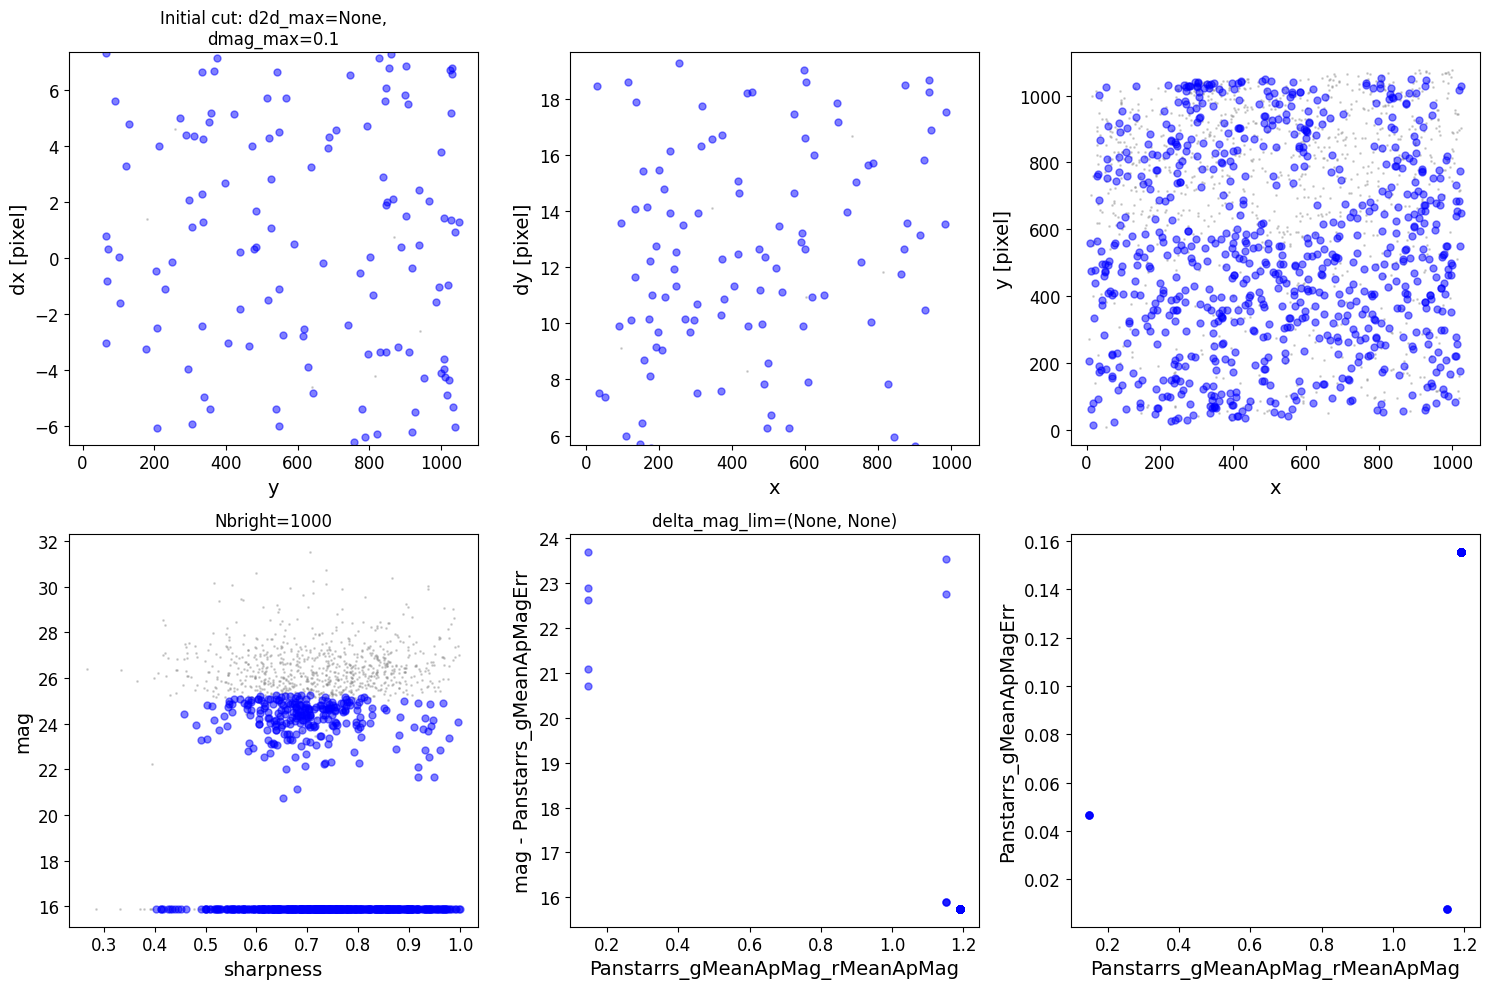

In [8]:
# show the initial dx, dy, centered around their respective medians
# blue symbols: measurements that make the initial cut using d2d_max, dmag_max, Nbright
# small gray symbols: didn't make the initial cut.
# goal of the initial cuts is to remove enough of the faint, spurious matches so that the
# loci of the good matches sticks at least a little out (visually)
if showplots>1:
    sp = initplot(2,3)
    # plot the residuals
    title = f'Initial cut: d2d_max={d2d_max},\ndmag_max={dmag_max}'
    title_Nbright = f'Nbright={Nbright}'
    title_deltamag = f'delta_mag_lim={delta_mag_lim}'
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim,title=title,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[0],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','y',ax=sp[2],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','y',ax=sp[2],ylabel='y [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[3],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[3],title=title_Nbright,ylabel='mag',**plot_style['good_data'])
    if wcs_align.phot.refcat_mainfilter is not None:
        if wcs_align.phot.refcat_maincolor is not None:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,'delta_mag',ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,'delta_mag',title=title_deltamag,ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],ylabel=f'{wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(6): sp[i].get_legend().remove()
        else:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',title=title_deltamag,ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(5): sp[i].get_legend().remove()
    else:
        for i in range(4): sp[i].get_legend().remove()

    plt.tight_layout()
    plt.show() 

In [9]:
%load_ext line_profiler


hello
-0.0048828125
-0.004833984375
-0.00478515625
-0.0047363281250000005
-0.004687500000000001
-0.004638671875000001
-0.004589843750000001
-0.004541015625000001
-0.004492187500000001
-0.0044433593750000016
-0.004394531250000002
-0.004345703125000002
-0.004296875000000002
-0.004248046875000002
-0.004199218750000002
-0.004150390625000003
-0.004101562500000003
-0.004052734375000003
-0.004003906250000003
-0.003955078125000003
-0.0039062500000000035
-0.0038574218750000036
-0.003808593750000004
-0.003759765625000004
-0.003710937500000004
-0.0036621093750000043
-0.0036132812500000045
-0.0035644531250000047
-0.003515625000000005
-0.003466796875000005
-0.003417968750000005
-0.0033691406250000054
-0.0033203125000000056
-0.0032714843750000057
-0.003222656250000006
-0.003173828125000006
-0.0031250000000000062
-0.0030761718750000064
-0.0030273437500000066
-0.0029785156250000068
-0.002929687500000007
-0.002880859375000007
-0.0028320312500000073
-0.0027832031250000075
-0.0027343750000000076
-0.00268

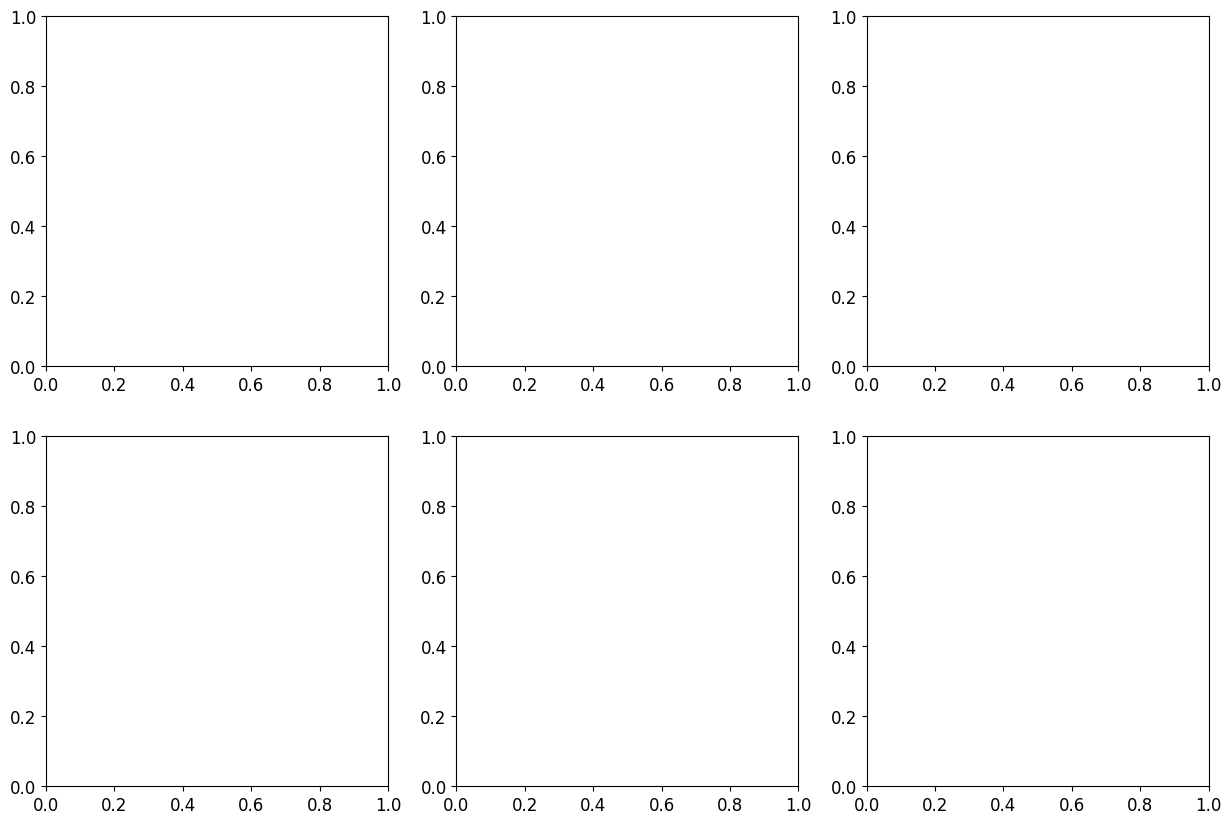


####################
### d_rotated cut
Keeping 11 out of 11, skippin 0 because of null values in columns d_rot_tmp
median: -15.781120
65.000000 percentile cut: max residual for cut: 0.133348
median: -15.781120
i:00 mean:-15.781120(0.023322) stdev:0.057127(0.015268) X2norm:0.92 Nchanged:0 Ngood:7 Nclip:4

mean: -15.797555
i:01 mean:-15.797555(0.029283) stdev:0.077476(0.019369) X2norm:1.00 Nchanged:1 Ngood:8 Nclip:3

mean: -15.797555
i:02 mean:-15.797555(0.029283) stdev:0.077476(0.019369) X2norm:1.00 Nchanged:0 Ngood:8 Nclip:3
i:02 mean:-15.797555(0.029283) stdev:0.077476(0.019369) X2norm:1.00 Nchanged:0 Ngood:8 Nclip:3


<Figure size 640x480 with 0 Axes>

In [10]:
# straight line.
def f(val,slope,intercept):
    return(val*slope+intercept)
import numpy as np
from pdastro import AnotB
from pdastro import makepath,rmfile,pdastroclass,AnotB
from jwst_wcs_align import find_info_for_maxval
from copy import copy
def sigmacut_d_rot(phot,ixs,
                   d_col,col,
                   slope,intercept,d_rot_bestguess,
                   rough_cut_px = 2.5, #This is the first rough cut:  get rid of everything d_rot_bestguess+-rough_cut_px
                   d_col_rot='d_rot_tmp',
                   binsize=0.5,
                   bin_weights_flag=True,
                   showplots=0,
                   sp=None,
                   spi=[0,1,2]):

    #phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
    ### recover the slope and intercept of the best binning
    phot.t[d_col_rot] = phot.t[d_col] - f(phot.t[col],slope,intercept)
    
    # Now make the rough cut! only keep data for with dx_rotated within  d_rot_bestguess+-rough_cut_px
    ixs_roughcut = phot.ix_inrange(d_col_rot,d_rot_bestguess-rough_cut_px,d_rot_bestguess+rough_cut_px,indices=ixs)
    d_rotated = phot.t.loc[ixs,d_col_rot]
    
    if showplots>1:
        if sp is None:
            sp=initplot(1,3)

        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        plot_rotated(phot,ixs_roughcut,
                     d_col,col,
                     d_col_rot=d_col_rot,
                     sp=sp,
                     spi=spi[:2],
                     bins=bins,
                     bin_weights_flag=bin_weights_flag,
                     histolim = (d_rot_bestguess-3*rough_cut_px,d_rot_bestguess+3*rough_cut_px),
                     title=f'First rough cut: {d_rot_bestguess:.3f}+-{rough_cut_px:.3f} for slope={slope:.6f}')

    print('\n####################\n### d_rotated cut')
    #ixs_clean4average = phot_clear.ix_inrange(d_col,0,3,indices=ixs_clear_cut)
    phot.calcaverage_sigmacutloop(d_col_rot,verbose=3,indices=ixs_roughcut,percentile_cut_firstiteration=65)
    print(phot.statstring())
    ixs_cut = phot.statparams['ix_good']

    if showplots>1:
        title = f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left\n'
        title += f'mean = {phot.statparams["mean"]:.3f} px, stdev = {phot.statparams["stdev"]:.3f} px'
        phot.t.loc[AnotB(ixs_roughcut,ixs_cut)].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='red', ms=5 ,alpha=0.3,title=title)
        phot.t.loc[ixs_cut].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='blue', 
                                 ms=5 ,alpha=0.3,ylabel=f'{d_col} [pixels]',
                                 title=title)
        if phot.ixs_notuse is not None:
            phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='gray', ms=1,alpha=0.5)
        sp[spi[2]].get_legend().remove()
    
        # set the appropriate y-axis limits
        (ylim_min,ylim_max) = (phot.t.loc[ixs_roughcut,d_col_rot].min(),phot.t.loc[ixs_roughcut,d_col_rot].max())
        ylim_min -= 0.1*(ylim_max-ylim_min)
        ylim_max += 0.1*(ylim_max-ylim_min)
        sp[spi[2]].set_ylim(ylim_min,ylim_max)
        #sp[spi[2]].set_ylim(sp[spi[2]].get_ylim(),(ylim_min,ylim_max))
        
        
        #phot.t.loc[ixs_roughcut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='red')
        #phot.t.loc[ixs_cut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='blue',
        #                                 ylabel='dx in pixels',
        #                                 title=f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left')
    return(ixs_cut,ixs_roughcut)

# plot the rotated dx or dy versus the original one
def plot_rotated(phot,ixs,d_col,col,
                 d_col_rot='d_rot_tmp',
                 sp=None,
                 spi=[0,1],
                 histolim=(-20,20),
                 bins=None,
                 bin_weights_flag=False,
                 title=None):
    if sp == None:
        sp=initplot(1,2)

    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,ax=sp[spi[0]],**plot_style['do_not_use_data'])
    phot.t.loc[ixs].plot(col,d_col,ax=sp[spi[0]],ylim=histolim,title=title,**plot_style['cut_data'])
    phot.t.loc[ixs].plot(col,d_col_rot,ax=sp[spi[0]],ylim=histolim,ylabel=f'{d_col} [pixels]',**plot_style['good_data'])
    sp[spi[0]].get_legend().remove()

    
    if bins is not None:
        if bin_weights_flag:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,
                                                weights=phot.t.loc[ixs,'__weights'],
                                                xlim=histolim,color='blue')
        else:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,xlim=histolim,color='blue')
        sp[spi[1]].set_xlabel(f'rotated {d_col}')
        #sp[spi[1]].get_legend().remove()
    return(sp)


# first, do the dx cut, since dx does not have the same contamination by shadow locii due to 
# the star spikes than dy.
slope_max=-slope_min
slope_stepsize=(slope_max-slope_min)/slope_Nsteps

# initialize dx plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
    
def plot_rotated(phot,ixs,d_col,col,
                 d_col_rot='d_rot_tmp',
                 sp=None,
                 spi=[0,1],
                 histolim=(-20,20),
                 bins=None,
                 bin_weights_flag=False,
                 title=None):
    if sp == None:
        sp=initplot(1,2)

    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,ax=sp[spi[0]],**plot_style['do_not_use_data'])
    phot.t.loc[ixs].plot(col,d_col,ax=sp[spi[0]],ylim=histolim,title=title,**plot_style['cut_data'])
    phot.t.loc[ixs].plot(col,d_col_rot,ax=sp[spi[0]],ylim=histolim,ylabel=f'{d_col} [pixels]',**plot_style['good_data'])
    sp[spi[0]].get_legend().remove()

    
    if bins is not None:
        if bin_weights_flag:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,
                                                weights=phot.t.loc[ixs,'__weights'],
                                                xlim=histolim,color='blue',histtype='step')
        else:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,xlim=histolim,color='blue',histtype='step')
        sp[spi[1]].set_xlabel(f'rotated {d_col}')
        #sp[spi[1]].get_legend().remove()
    return(sp)    

def plot_rotated_grid(results,ixs,d_col,col,
                 d_col_rot='d_rot_tmp',
                 sp=None,
                 spi=[0,1],
                 histolim=(-20,20),
                 bins=None,
                 bin_weights_flag=False,
                 titles=None):
    if sp == None:
        sp=initplot(1,2)
    nrows = int(np.ceil(np.sqrt(len(results))))
    fig,axes = plt.subplots(nrows,nrows,sharex=False,sharey=True)
    row,col = 0,0
    for i in range(len(results)):
        print('plotting %i of %i'%(i,len(results)),nrows,i,row,col,bins)
        
        if i%nrows==0 and i>0:
            row+=1
            col = 0
        elif i>0:
            col+=1
        ax = axes[row][col]
        phot = results[i]
        if phot.ixs_notuse is not None:
            phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,ax=ax,**plot_style['do_not_use_data'],)
        phot.t.loc[ixs].plot(col,d_col,ax=ax,ylim=histolim,title=titles[i],**plot_style['cut_data'])
        phot.t.loc[ixs].plot(col,d_col_rot,ax=ax,ylim=histolim,ylabel=f'{d_col} [pixels]',**plot_style['good_data'])
        
        ax.get_legend().remove()
        
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(10)
        continue
        if bins is not None:
            if bin_weights_flag:
                phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,
                                                    weights=phot.t.loc[ixs,'__weights'],
                                                    xlim=histolim,color='blue')
            else:
                phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,xlim=histolim,color='blue')
            ax.set_xlabel(f'rotated {d_col}')
        #sp[spi[1]].get_legend().remove()
    return(axes)

def rotate_d_and_find_binmax(phot,ixs,d_col,col,
                             Naxis_px, # Nx or Ny, depending on col
                             d_col_rot='d_rot_tmp',
                             binsize=0.5,
                             bin_weights_flag=True,
                             slope_min=-10.0/2048.0, # 
                             slope_max=10.0/2048.0, # 
                             slope_stepsize=1.0/2048,
                             showplots=0,
                             sp=None,
                             spi=[0,1,2]):
    rot_results = pdastroclass()

    if bin_weights_flag:
        phot.t.loc[ixs,'__weights']=10**(-0.4*phot.t.loc[ixs,'mag'])
    else:
        phot.t.loc[ixs,'__weights']=None
        
    slopes = np.arange(slope_min,slope_max,slope_stepsize)
    results = []
    for slope in slopes:
        print(slope)
        #slope = delta4slope_pix/Nx
        intercept = -0.5*Naxis_px * slope

        #phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
        phot.t[d_col_rot] = phot.t[d_col] - f(phot.t[col],slope,intercept)

        # get the histogram
        d_rotated = phot.t.loc[ixs,d_col_rot]
        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        if bin_weights_flag:
            histo = np.histogram(d_rotated,bins=bins,weights=phot.t.loc[ixs,'__weights'])
        else:
            histo = np.histogram(d_rotated,bins=bins)
        #sp = plt.subplot(111)
        #print(histo[1])
        #sp.plot(histo[1][1:], histo[0], 'ro')
        # get the max value of the histogram, and its associated bin center. Note that the bincenter is 
        # the value in the bins (left edge of the bin) + the half of the binsize
        (bincenter4maxval,maxval,index_maxval,fwhm,multiple_max) = find_info_for_maxval(histo[1]+0.5*binsize,histo[0])

        # Save the results
        rot_results.newrow({'slope':slope,
                            'intercept':intercept,
                            'maxval':maxval,
                            'index':index_maxval,
                            'd_bestguess':bincenter4maxval,
                            'fwhm':fwhm,
                            'multimax':multiple_max
                            })
        results.append(copy(phot))
        if showplots>2:
            plot_rotated(phot,ixs,
                     d_col,col,
                     d_col_rot=d_col_rot,
                     bins=bins,
                     bin_weights_flag=bin_weights_flag,
                     histolim = (bincenter4maxval-8,bincenter4maxval+8),
                     title='slope:%.5f'%slope )
#     sys.exit()
    
#     # plot it if wanted
#     if showplots>2:
#         plot_rotated_grid(results,ixs,
#                      d_col,col,
#                      d_col_rot=d_col_rot,
#                      bins=bins,
#                      bin_weights_flag=bin_weights_flag,
#                      histolim = (bincenter4maxval-8,bincenter4maxval+8),
#                      titles=['slope:%.5f'%slope for slope in slopes])
#     #sys.exit(0)
#     plt.tight_layout() 
#     plt.show()
    # print the results        
    rot_results.write()
    
    # find the best rotation
    maxmaxval = np.max(rot_results.t['maxval'])
    ixs_maxmax = np.where(rot_results.t['maxval']==maxmaxval)
    if (len(ixs_maxmax[0])==0):
        raise RuntimeError('BUUUUGGGG!!!!')
    elif (len(ixs_maxmax[0])>1):
        #print(f'\nWARNING!! more than one bin with maxvalue={maxmaxval}!')
        multiple_max=True
        best_index=ixs_maxmax[0][0]
    else:
        multiple_max=False
        best_index=ixs_maxmax[0][0]
    print('####BEST:')
    rot_results.write(indices=[best_index])
    
    if showplots>1:
        if sp is None:
            sp = initplot(1,3)
        rot_results.t.plot('slope','maxval',ax=sp[spi[0]],color='blue',title=f'{d_col}',ylabel='histogran peak value')
        rot_results.t.plot.scatter('slope','d_bestguess',ax=sp[spi[1]],color='blue',title=f'{d_col}')
        rot_results.t.plot.scatter('slope','fwhm',ax=sp[spi[2]],color='blue',title=f'{d_col}')
        sp[spi[0]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
        sp[spi[1]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
        sp[spi[2]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
    
    
    return(rot_results,best_index)
import matplotlib
#matplotlib.use('TkAgg')
#showplots=3
import time
t = time.time()
bin_weights_flag=0
showplots=0
(dx_rot_results,dx_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs,'dx','y',
                                                          Ny,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])
t2 = time.time()
print(t2-t)     
plt.show()
#sys.exit()
# Using the best dx_rotated, we first remove all entries with dx_rotated outside of dx_bestguess+-Nfwhm*fwhm
# Note that FWHM ~ 2.355 stdev, so Nfwhm*fwhm should be at least 3*stdev. This is the first ROUGH cut, with 
# which we just want to remove excessive amounts of outliers. Then a 3-sigma cut is done on the *rotated* dx
(ixs_dx_cut,ixs_dx_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs,'dx','y',
                                              dx_rot_results.t.loc[dx_best_index,'slope'],
                                              dx_rot_results.t.loc[dx_best_index,'intercept'],
                                              dx_rot_results.t.loc[dx_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dx_rot_results.t.loc[dx_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        

# top plots: histogram peak value, best guess of rotated dx offset, and fwhm with respect to the slopes.
# The red line indicates the best slope
# bottom plots:
# first rough cut is best guess of rotated dx offset +- Nfwhm*fwhm
# bottom left: red is dx, blue is the best rotated dx. small gray circles did not make initial cut
# bottom middle: histogram of rotated dx: this peak value should be the same as the peak in top left plot
# bottom right: 3-sigma cut getting rid of outliers still in the rough cut

In [11]:
# Using the indices after the dx cut, we now also do a dy cut
# slope in dy is the -slope of dx.
slope = -dx_rot_results.t.loc[dx_best_index,'slope']
# We only need to do it +-10*stepsize
slope_min = slope-10*slope_stepsize
slope_max = slope+10*slope_stepsize

# initialize dy plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
(dy_rot_results,dy_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs_dx_cut,'dy','x',
                                                          Nx,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize/5.0,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])
(ixs_dy_cut,ixs_dy_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs_dx_cut,'dy','x',
                                              dy_rot_results.t.loc[dy_best_index,'slope'],
                                              dy_rot_results.t.loc[dy_best_index,'intercept'],
                                              dy_rot_results.t.loc[dy_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dy_rot_results.t.loc[dy_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        


0.004296875
0.004306640625
0.00431640625
0.004326171875
0.0043359374999999995
0.004345703124999999
0.004355468749999999
0.004365234374999999
0.004374999999999999
0.0043847656249999985
0.004394531249999998
0.004404296874999998
0.004414062499999998
0.004423828124999998
0.004433593749999997
0.004443359374999997
0.004453124999999997
0.004462890624999997
0.004472656249999997
0.004482421874999996
0.004492187499999996
0.004501953124999996
0.004511718749999996
0.0045214843749999956
0.004531249999999995
0.004541015624999995
0.004550781249999995
0.004560546874999995
0.0045703124999999945
0.004580078124999994
0.004589843749999994
0.004599609374999994
0.004609374999999994
0.0046191406249999935
0.004628906249999993
0.004638671874999993
0.004648437499999993
0.004658203124999993
0.0046679687499999924
0.004677734374999992
0.004687499999999992
0.004697265624999992
0.004707031249999992
0.004716796874999991
0.004726562499999991
0.004736328124999991
0.004746093749999991
0.0047558593749999906
0.00476562499

<Figure size 640x480 with 0 Axes>

In [12]:

if savephottable:
    print(f'Saving {outbasename}.good.phot.txt')
    wcs_align.phot.write(f'{outbasename}.good.phot.txt',indices=ixs_dy_cut)
    if savephottable>1:
        print(f'Saving {outbasename}.all.phot.txt')
        wcs_align.phot.write(f'{outbasename}.all.phot.txt')

#if showplots>1:
#    # get the bad data points
#    infoplots(wcs_align.phot,ixs_dy_cut,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)
            



Saving /Users/jpierel/CodeBase/manuscript_jupyter/sn2013ej/HST/ICW701030/icw701030_drc.good.phot.txt
Saving /Users/jpierel/CodeBase/manuscript_jupyter/sn2013ej/HST/ICW701030/icw701030_drc.all.phot.txt


In [13]:
# Now align to the reference catalog ONLY using the best matches after the dy cut
# This alignment is done using a hacked version of tweakreg by Justin Pierel: only the part of tweakreg
# is used that does the rshift (rotation+translation) FITTING (only the fitting, no matching! 
# It uses the matches from wcs_align.phot.t[ixs_bestmatch])
ixs_bestmatch = ixs_dy_cut

(runflag,tweakregfilename) = wcs_align.run_align2refcat(calimname,ixs=ixs_bestmatch,
                                                   overwrite=overwrite,skip_if_exists=skip_if_exists)
print('DONE!')
sys.exit()

2022-09-22 16:21:16,915 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2022-09-22 16:21:16,962 - stpipe - WARNING - /Users/jpierel/miniconda3/envs/tweakreg/lib/python3.10/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.name the following error occurred:
'WFC3' is not one of ['NIRCAM', 'NIRSPEC', 'MIRI', 'TFI', 'FGS', 'NIRISS', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Instrument used to acquire the data'),
                 ('type', 'string'),
                 ('enum',
                  ['NIRCAM',
                   'NIRSPEC',
                   'MIRI',
                   'TFI',
                   'FGS',
                   'NIRISS',
                   'ANY',
                   'N/A']),
                 ('fits_keyword', 'INSTRUME'),
                 ('blend_table', True)])

On instance:
    'WFC3'
  warnings.warn(errmsg, ValidationWarning)

2022-09-22 16:21:16,964 - stpipe - WARNING - /User

2022-09-22 16:21:17,288 - stpipe.TweakRegStep - INFO - NUMBER OF IMAGES: 1
2022-09-22 16:21:17,290 - stpipe.TweakRegStep - INFO - Detected 2 sources in icw701030_drc.fits.
2022-09-22 16:21:17,308 - stpipe.TweakRegStep - INFO - 
2022-09-22 16:21:17,309 - stpipe.TweakRegStep - INFO - Number of image groups to be aligned: 1.
2022-09-22 16:21:17,309 - stpipe.TweakRegStep - INFO - Image groups:


./test/wcs_align/v1/icw701030_tweakregstep.fits
Setting output directory for tweakregstep.fits file to ./test/wcs_align/v1
2 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=Panstarrs_ra,Panstarrs_dec


AttributeError: No attribute 'wcs'

In [ ]:
#print(wcs.WCS(fits.open('justin/v1/jw01069002002_04101_00001_nrcb4_tweakregstep.fits')[1]))
#print(wcs.WCS(fits.open('test/wcs_align/v1/jw01069002002_04101_00001_nrcb4_tweakregstep.fits')[1]))
print(list(jwst.datamodels.open('justin/v1/jw01069002002_04101_00001_nrcb4_tweakregstep.fits').meta.__dict__['_ctx'].keys()))

In [ ]:

wcs_align.update_phottable_final_wcs(tweakregfilename,
                                ixs_bestmatch = ixs_bestmatch,
                                showplots=showplots,
                                saveplots=saveplots,
                                savephottable=savephottable,
                                overwrite=overwrite
                                )


In [ ]:
#####  IGNORE BELOW!!! TESTING!!!
import copy
bkp = copy.deepcopy(wcs_align)

In [ ]:
wcs_align = copy.deepcopy(bkp)
print(wcs_align.phot.t.columns,wcs_align.phot.refcatshort)
for col in wcs_align.phot.t.columns:
    if re.search(f'^{wcs_align.phot.refcatshort}',col) is not None:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
        print(col)
    if re.search(f'^_',col) is not None:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
        print(col)
for col in ['ra','dec','dx','dy','d_rot_tmp','delta_mag']:
    if col in wcs_align.phot.t.columns:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
   
print('Done!')
print(wcs_align.phot.t.columns,wcs_align.phot.refcatshort)


In [ ]:
print(tweakregfilename)
wcs_align.phot.run_phot(tweakregfilename,do_photometry_flag=False,
                 photcat_loaded = True,rematch_refcat=True,refcatname='hawki')

In [ ]:
# Now we find good refcat matches. This is 
# done in jwst_wcs_align.find_good_refcat_matches(), but 
# we will do it below step by step, since this is the most
# important step in this process

# here are a few more fine-tuning parameters

# The y-axes limits of the first plots are the mean of dx/dy +-plots_dxdy_delta_pix_ylim
plots_dxdy_delta_pix_ylim=7

# histo parameters
binsize_px = 0.2 # this is the binsize of the dx/dy histograms. 
                 # A good value is 0.1, which should be on the order 
                 # of the expected stdev of dx if things are good
bin_weights_flag=True # If bin_weights_flag is set to True, 
                      # then the dx/dy bins are weighted by 
                      # the flux of the detection. This enhances 
                      # the signal in the histogram since real 
                      # matches in general have more flux than spurious matches

# dx/dy are corrected by a linear function with a slope (i.e., the effect a rotation would have on it), and 
# then a histogram of this "rotated" dx/dy is done, and the peak of that
# histogram is determined. This is done for a set of slopes, which is defined
# with slope_min, slope_Nsteps, and then 
# slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
# slope=-10.0/2048.0 would correspond to the slope of a linear function for wich dx changes by 
# 10 pixels of the full detector size of 2048 pixels
slope_min=-10.0/2048.0 
slope_Nsteps = 200 # slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
Nfwhm = 2

# basename for output files, e.g., plots
outbasename = re.sub('\.fits$','',calimname)
if (outbasename == calimname): raise RuntimeError(f'Could not remove .fits from {calimname}')        

# use all the data in the photometric catalog if ixs=None
ixs=None

if (saveplots or savephottable) and (outbasename is None):
    raise RuntimeError('Trying to save plots and/or phot tables, but outbasename is None!')

Nx = wcs_align.phot.scihdr['NAXIS1']
Ny = wcs_align.phot.scihdr['NAXIS2']

refcat_xcol = wcs_align.phot.refcat_xcol
refcat_ycol = wcs_align.phot.refcat_ycol
xcol='x'
ycol='y'

# Calculate dx and dy
wcs_align.phot.t['dx'] = wcs_align.phot.t[refcat_xcol] - wcs_align.phot.t[xcol]
wcs_align.phot.t['dy'] = wcs_align.phot.t[refcat_ycol] - wcs_align.phot.t[ycol]
# Calculate the difference between JWST mag and main filter of reference catalog
if wcs_align.phot.refcat_mainfilter is not None:
    wcs_align.phot.t['delta_mag'] = wcs_align.phot.t['mag'] - wcs_align.phot.t[wcs_align.phot.refcat_mainfilter]

sharpness_lim = (0.4,1.0)
delta_mag_lim=(None,None)#-26, -22)
# do some first very rough cuts.
# sets phot.ixs_use and phot.ixs_notuse
# returns phot.ixs_use
ixs = wcs_align.initial_cut(phot=wcs_align.phot,
                       d2d_max=d2d_max,
                       dmag_max=dmag_max,
                       Nbright=Nbright,
                       sharpness_lim=sharpness_lim,
                       delta_mag_lim=delta_mag_lim,
                       ixs=ixs)

dx_median = wcs_align.phot.t.loc[ixs,'dx'].median()
dy_median = wcs_align.phot.t.loc[ixs,'dy'].median()

if wcs_align.verbose>1: print(f'Nx:{Nx} Ny:{Ny}\ndx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the dx/dy plots
dy_plotlim = (dy_median-plots_dxdy_delta_pix_ylim,dy_median+plots_dxdy_delta_pix_ylim)
dx_plotlim = (dx_median-plots_dxdy_delta_pix_ylim,dx_median+plots_dxdy_delta_pix_ylim)

plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}
# show the initial dx, dy, centered around their respective medians
# blue symbols: measurements that make the initial cut using d2d_max, dmag_max, Nbright
# small gray symbols: didn't make the initial cut.
# goal of the initial cuts is to remove enough of the faint, spurious matches so that the
# loci of the good matches sticks at least a little out (visually)
if showplots>1:
    sp = initplot(2,3)
    # plot the residuals
    title = f'Initial cut: d2d_max={d2d_max},\ndmag_max={dmag_max}'
    title_Nbright = f'Nbright={Nbright}'
    title_deltamag = f'delta_mag_lim={delta_mag_lim}'
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim,title=title,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[0],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','y',ax=sp[2],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','y',ax=sp[2],ylabel='y [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[3],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[3],title=title_Nbright,ylabel='mag',**plot_style['good_data'])
    if wcs_align.phot.refcat_mainfilter is not None:
        if wcs_align.phot.refcat_maincolor is not None:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,'delta_mag',ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,'delta_mag',title=title_deltamag,ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],ylabel=f'{wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(6): sp[i].get_legend().remove()
        else:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',title=title_deltamag,ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(5): sp[i].get_legend().remove()
    else:
        for i in range(4): sp[i].get_legend().remove()

    plt.tight_layout()
    plt.show() 